#  XGB Model

In [1]:
import datetime
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

'''for saving models'''
from joblib import dump, load

In [95]:
# MANIFEST - list of versions on board 
import sys
import os
print(pd.datetime.now())
print('OS: '+os.uname().sysname)
print('Python: '+sys.version)
print('matplotlib: '+mpl.__version__)
print('numpy: '+np.__version__)
print('pandas: '+pd.__version__)
print('sklearn: '+sklearn.__version__)

2020-02-11 17:40:01.753899
OS: Linux
Python: 3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
matplotlib: 3.1.1
numpy: 1.17.2
pandas: 0.25.1
sklearn: 0.21.3


In [3]:
import xgboost as xgb
print('xgboost: '+xgb.__version__)

xgboost: 0.90


In [4]:
# https://askubuntu.com/questions/5417/how-to-get-the-gpu-info
# might want to conditinally set the 'tree_method' parameter to xbgoost based on the return to this call
! lspci  -v -s  $(lspci | grep ' VGA ' | cut -d" " -f 1) | grep 'controller'

01:00.0 VGA compatible controller: NVIDIA Corporation GP102 [GeForce GTX 1080 Ti] (rev a1) (prog-if 00 [VGA controller])


In [5]:
def xgb_progressbar(rounds=1000):
    """Progressbar for xgboost using tqdm library.
    https://programtalk.com/python-examples/tqdm/
    example: model = xgb.train(params, X_train, 1000, callbacks=[xgb_progressbar(100), ])
    """
    from tqdm.auto import tqdm
    pbar = tqdm(total=rounds)

    def callback(_, ):
        pbar.update(1)

    return callback

## Data Prep

In [6]:
FOLDER = '../mortality_prediction_docker_model/v2/scratch/'
train_file = FOLDER+'train_all.csv'
train = pd.read_csv(train_file,low_memory = False)
train.shape

(278998, 234)

In [7]:
train.head()

,person_id,days_since_latest_visit,ethnicity_concept_id,race_concept_id,gender_concept_id,race_concept_name,number_of_visits,visit_concept_name,visit_duration,death_in_next_window,...,procedure_concept_2314215,drug_concept_19033627,procedure_concept_2313850,procedure_concept_2109792,procedure_concept_2003939,condition_concept_81723,procedure_concept_2110916,procedure_concept_2314207,procedure_concept_2003789,observation_concept_40757059
0,0,45,NaN,8552.0,8507,Unknown,4,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,31,NaN,8557.0,8507,Native Hawaiian or Other Pacific Islander,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6,103,NaN,8527.0,8532,White,3,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,84,38003564.0,8552.0,8532,Unknown,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12,2,NaN,8516.0,8532,Black or African American,2,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
cols = pd.DataFrame([[c.split('_')[-1] for c in train.columns],train.columns]).T
cols.columns =['concept_id','column']
cols.concept_id[0:21] = 0 # the first are strings
cols.concept_id = cols.concept_id.astype(int)
cols.iloc[20:25]

,concept_id,column
20,0,days_since_latest_observation
21,38000269,procedure_type_38000269
22,4214956,observation_concept_4214956
23,38000282,observation_type_38000282
24,2002291,procedure_concept_2002291


In [10]:
all_concepts = pd.read_csv('v2/app/concept_codes_final/all_concepts.csv')
all_concepts.head()

,concept_id,concept_name,vocabulary_id,table
0,3000453,Epstein Barr virus DNA [#/volume] (viral load)...,LOINC,measurement
1,3000515,Antithrombin actual/normal in Platelet poor pl...,LOINC,measurement
2,3000722,Carnitine free (C0) [Moles/volume] in Serum or...,LOINC,measurement
3,3001405,CD3+CD8+ (T8 suppressor cells) cells [#/volume...,LOINC,measurement
4,3001599,Carotene [Mass/volume] in Serum,LOINC,measurement


In [11]:
col_concepts = cols.set_index('concept_id').join(all_concepts.set_index('concept_id'), how='left')
col_concepts.head()

,column,concept_name,vocabulary_id,table
concept_id,,,,
0,person_id,NaN,NaN,NaN
0,days_since_latest_visit,NaN,NaN,NaN
0,ethnicity_concept_id,NaN,NaN,NaN
0,race_concept_id,NaN,NaN,NaN
0,gender_concept_id,NaN,NaN,NaN


In [12]:
col_concepts.tail()

,column,concept_name,vocabulary_id,table
concept_id,,,,
40483287,condition_concept_40483287,Disorder of kidney and/or ureter,SNOMED,condition_occurrence
40757059,observation_concept_40757059,NaN,NaN,NaN
43011909,drug_concept_43011909,NaN,NaN,NaN
43021378,observation_concept_43021378,Suspected infectious disease,SNOMED,observation
43531028,condition_concept_43531028,Mononeuropathy of lower limb,SNOMED,condition_occurrence


In [13]:
# What % oc concept_id's don't have a corresponding concept code?
round(col_concepts.isnull().sum().table / col_concepts.shape[0], 2)*100

53.0

In [14]:
all_concepts[all_concepts.concept_id == 38000200]

,concept_id,concept_name,vocabulary_id,table


In [15]:
start_mem = train.memory_usage().sum() / 1024**2
print('Memory usage is {:.2f} MB'.format(start_mem))

Memory usage is 498.09 MB


In [16]:
def cols_toint(df):
    df = df.fillna(0)
    df.old = df.old.astype(int)
    for c in df.columns[df.columns.str.startswith('days')]:
        df[c] = df[c].astype(int)
    return df

In [17]:
train = cols_toint(train)

In [18]:
def reduce_mem_usage(df):
    '''https://www.mikulskibartosz.name/how-to-reduce-memory-usage-in-pandas/'''
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and col_type :
                c_min = df[col].min()
                c_max = df[col].max()
                c_unique = len(df[col].unique())

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                        df[col] = df[col].astype(np.uint8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                        df[col] = df[col].astype(np.uint16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                        df[col] = df[col].astype(np.uint32)                    
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                    elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)

                if c_min == 0.0 and c_max == 1.0 and c_unique == 2:
                    df[col] = df[col].astype(bool)
                    pass
                
#                 if 2 > c_unique and c_unique < 21: # convert to categorical - needs more work
#                     df[col] = pd.Categorical(df[col])


    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [19]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 498.09 MB
Memory usage after optimization is: 68.91 MB
Decreased by 86.2%


In [20]:
train.head()

,person_id,days_since_latest_visit,ethnicity_concept_id,race_concept_id,gender_concept_id,race_concept_name,number_of_visits,visit_concept_name,visit_duration,death_in_next_window,...,procedure_concept_2314215,drug_concept_19033627,procedure_concept_2313850,procedure_concept_2109792,procedure_concept_2003939,condition_concept_81723,procedure_concept_2110916,procedure_concept_2314207,procedure_concept_2003789,observation_concept_40757059
0,0,45,0.0,8552.0,8507,Unknown,4,0,0,False,...,False,False,False,False,False,False,False,False,False,False
1,5,31,0.0,8560.0,8507,Native Hawaiian or Other Pacific Islander,1,1,0,False,...,False,False,False,False,False,False,False,False,False,False
2,6,103,0.0,8528.0,8532,White,3,0,0,False,...,False,False,False,False,False,False,False,False,False,False
3,10,84,38003564.0,8552.0,8532,Unknown,1,0,0,False,...,False,False,False,False,False,False,False,False,False,False
4,12,2,0.0,8512.0,8532,Black or African American,2,0,0,False,...,False,False,False,False,False,False,False,False,False,False


In [21]:
def find_dup_cols(df_in):
    '''
    Find duplicate columns:
    >>> df = pd.DataFrame([[1,1,4], [2,2,5], [3,3,6]], columns=['a','b','c']); find_dup_cols(df)
    ['b', 'c']
    '''
    from tqdm import tqdm

    df = df_in.copy(deep=True)
    i = 1
    dupes = []
    for c in tqdm(df.columns):
        if c not in df.columns: # a column could have been deleted
            pass
        for d in df.columns[i:]: # for every subsequent column
            if len(pd.Series(list(zip(df[c], df[d]))).unique()) == len(df[c].unique()) == len(df[d].unique()):
                dupes += d
                df = df.drop(d, axis=1)
        i += 1
    return dupes

from doctest import testmod
testmod(name='find_dup_cols')

100%|██████████| 3/3 [00:00<00:00, 1058.45it/s]


TestResults(failed=0, attempted=1)

In [22]:
# %%time
# # expensive, don't do this if you don't have time
# find_dup_cols(train)

In [23]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train.race_concept_name = train.race_concept_name.replace(to_replace=0, value='Unknown')
train.race_concept_name = train.race_concept_name.fillna('Unknown')
label_encoder = label_encoder.fit(train.race_concept_name)
train.race_concept_name = label_encoder.transform(train.race_concept_name)

In [24]:
train.describe(include='all').T.fillna('')

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
person_id,278998.0,,,,75818.2,43668.1,0,38065,75703,113636,151684
days_since_latest_visit,278998.0,,,,63.4859,51.9673,1,18,50,100,180
ethnicity_concept_id,278998.0,,,,2.12587e+07,1.88731e+07,0,0,3.80036e+07,3.80036e+07,3.80036e+07
race_concept_id,278998.0,,,,,,0,8512,8528,8560,8656
gender_concept_id,278998.0,,,,8521.07,12.4016,8507,8507,8532,8532,8532
...,...,...,...,...,...,...,...,...,...,...,...
condition_concept_81723,278998.0,2,False,278893,,,,,,,
procedure_concept_2110916,278998.0,2,False,278957,,,,,,,
procedure_concept_2314207,278998.0,2,False,278048,,,,,,,
procedure_concept_2003789,278998.0,2,False,278967,,,,,,,


In [25]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
person_id,278998.0,7.581821e+04,4.366814e+04,0.0,38065.0,75703.0,113636.0,151684.0
days_since_latest_visit,278998.0,6.348594e+01,5.196734e+01,1.0,18.0,50.0,100.0,180.0
ethnicity_concept_id,278998.0,2.125874e+07,1.887310e+07,0.0,0.0,38003564.0,38003564.0,38003564.0
race_concept_id,278998.0,NaN,NaN,0.0,8512.0,8528.0,8560.0,8656.0
gender_concept_id,278998.0,8.521065e+03,1.240165e+01,8507.0,8507.0,8532.0,8532.0,8532.0
race_concept_name,278998.0,2.705618e+00,1.667634e+00,0.0,1.0,3.0,4.0,5.0
number_of_visits,278998.0,3.973584e+00,9.905619e+00,1.0,1.0,2.0,3.0,465.0
visit_concept_name,278998.0,6.089649e-01,1.694314e+00,0.0,0.0,0.0,1.0,65.0
visit_duration,278998.0,6.954709e-01,3.339940e+00,0.0,0.0,0.0,0.0,138.0
old,278998.0,7.205466e+01,1.259637e+01,0.0,67.0,73.0,80.0,101.0


In [26]:
train.shape

(278998, 234)

In [27]:
#train = train.drop(train.columns[train.columns.str.startswith('days_since')], axis=1)

In [28]:
X = train.drop(['death_in_next_window','person_id'], axis = 1)
train_features = X.columns.values
y = train[['death_in_next_window']]
X = np.array(X)
y = np.array(y).ravel()

In [29]:
# # there are no duplicates
# train_nodup = train.drop_duplicates()
# train_nodup.shape

## Test

In [30]:
test_file = FOLDER+'test_all.csv'
test = pd.read_csv(test_file,low_memory = False)
test.shape

(118781, 27)

In [31]:
test = cols_toint(test)
test.shape

ValueError: invalid literal for int() with base 10: '37 days 00:00:00.000000000'

In [ ]:
test.race_concept_name = test.race_concept_name.replace(to_replace=0, value='Unknown')
test.race_concept_name = test.race_concept_name.fillna('Unknown')
test.race_concept_name = label_encoder.transform(test.race_concept_name)

In [ ]:
#test = test.drop(test.columns[test.columns.str.startswith('days_since')], axis=1)

In [ ]:
X_test = test.drop(['person_id'], axis = 1)
X_test = X_test[train_features]  # order the test columns like train
test_features = X_test.columns.values
X_test = np.array(X_test)

In [ ]:
person = pd.read_csv(FOLDER+'../infer/person.csv')
visit = pd.read_csv(FOLDER+'../infer/visit_occurrence.csv')
cols = ['person_id','visit_start_date']
visit = visit[cols]
death = pd.read_csv(FOLDER+'../infer/death.csv')
cols = ['person_id','death_date']
death = death[cols]
visit_death = pd.merge(death,visit,on=['person_id'],how='inner')
visit_death['death_date'] = pd.to_datetime(visit_death['death_date'], format='%Y-%m-%d')
visit_death['visit_start_date'] = pd.to_datetime(visit_death['visit_start_date'], format='%Y-%m-%d')
visit_death['last_visit_death'] = visit_death['death_date'] - visit_death['visit_start_date']
visit_death['last_visit_death'] = visit_death['last_visit_death'].apply(lambda x: x.days)
visit_death = visit_death.loc[visit_death['last_visit_death'] <= 180]
visit_death.drop_duplicates(subset=['person_id'], keep = 'first',inplace = True)
visit_death = visit_death[['person_id','visit_start_date']]
visit_death.columns = ['person_id','prediction_date']
visit_death['death'] = np.ones(visit_death.shape[0])
visit_live = visit[~visit.person_id.isin(visit_death.person_id)]
visit_live = visit_live[['person_id','visit_start_date']]

In [ ]:
visit_death.death = visit_death.death.astype(int)
visit_death = visit_death.set_index('person_id')
visit_death = visit_death.drop('prediction_date', axis=1)
visit_death.head()

In [ ]:
visit_death.shape

In [ ]:
y_test = pd.DataFrame(index=person.person_id)
y_test['death'] = 0
y_test.death = visit_death.death
y_test = y_test.fillna(0)
y_test = y_test.astype(int)
y_test.shape

In [ ]:
y_test.head()

In [ ]:
y_test.death.sum()

In [ ]:
20 % 10

## XGB Model

In [96]:
def plot_perf_i(evals_result, nth=10): 
    '''interactive plot model performance over epochs interactive'''
    from IPython.display import display, clear_output
    fig, ax1 = plt.subplots(1,1, figsize=(10,5))
#    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
    plt.ion()
    display(fig)
    counter = 0
    
    def callback(_,): #, fig, ax1, ax2):
        if evals_result == {}: # skip the empty dict  
            return callback

        epochs = len(evals_result['train']['auc'])
        if epochs % nth != 0:  # only plasdfot every nth iteration
            return callback

        clear_output(wait=True)  # plot over the previous picture
        x_axis = range(0, epochs)
        ax1.plot(x_axis, evals_result['train']['auc'], label='Train ', c='g')
        ax1.plot(x_axis, evals_result['valid']['auc'], label='Valid ', c='b')
        ax1.ticklabel_format(useOffset=False, style='plain')
        # ax1.legend()  # legends are messy and result in duplicates
        ax1.set_ylabel('AUC')
        ax1.set_title('XGBoost AUC ')
        ax1.grid(True)

        # needs to be generalized ??? 
#         ax2.plot(x_axis, evals_result['train']['error'], label='Train ', c='g')
#         ax2.plot(x_axis, evals_result['valid']['error'], label='Valid ', c='b')
#         ax2.ticklabel_format(useOffset=False, style='plain')
#         # ax2.legend()
#         ax2.set_ylabel('Classification Error')
#         ax2.set_title('XGBoost Classification Error')
#         ax2.grid(True)

        display(fig)
        plt.close()

    return callback

In [33]:
def old_plot_perf(evals_result, best):
    ''' plot all model performance metrics over epochs '''
    epochs = len(evals_result['train']['auc'])
    x_axis = range(0, epochs)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
    ax1.plot(x_axis, evals_result['train']['auc'], label='Train '+str(evals_result['train']['auc'][best]), c='g')
    ax1.plot(x_axis, evals_result['valid']['auc'], label='Valid '+str(evals_result['valid']['auc'][best]), c='b')
    ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.axvline(x=xgb_model.best_ntree_limit, color='r', label='best '+str(xgb_model.best_ntree_limit))
    ax1.grid(True)
    ax1.legend()
    ax1.set_ylabel('AUC')
    ax1.set_title('XGBoost AUC ')
    ax2.plot(x_axis, evals_result['train']['error'], label='Train '+str(evals_result['train']['error'][-1]), c='g')
    ax2.plot(x_axis, evals_result['valid']['error'], label='Valid '+str(evals_result['valid']['error'][best]), c='b')
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.axvline(x=xgb_model.best_ntree_limit, color='r', label='best '+str(xgb_model.best_ntree_limit))
    ax2.grid(True)
    ax2.legend()
    ax2.set_ylabel('Classification Error')
    ax2.set_title('XGBoost Classification Error')
    plt.show()

In [86]:
def plot_perf(evals_result, best):
    ''' plot all model performance metrics over epochs'''
    keys = list(evals_result.keys())
    metrics = list(evals_result[keys[0]].keys())
    epochs = len(evals_result[keys[0]][metrics[0]])
    num_plots = len(metrics)
    x_axis = range(0, epochs)
    fig, axs = plt.subplots(num_plots, 1, figsize=(10,5*num_plots))
    for p in range(num_plots):
        axs[p].plot(x_axis, evals_result[keys[0]][metrics[p]], 
                    label=keys[0]+' '+str(evals_result[keys[0]][metrics[p]][best]), c='g')
        axs[p].plot(x_axis, evals_result[keys[1]][metrics[p]], 
                    label=keys[1]+' '+str(evals_result[keys[1]][metrics[p]][best]), c='b')
        axs[p].ticklabel_format(useOffset=False, style='plain')
        axs[p].axvline(x=best, color='r', label='best '+str(best))
        axs[p].grid(True)
        axs[p].legend()
        axs[p].set_ylabel(metrics[p])
        axs[p].set_title(metrics[p])
    plt.show()

In [93]:
random_state = 1234
num_round = 2000
early_stop = round(num_round / 10)  # 10% of the full rounds
metrics = ['auc']                   # faster with fewer metrics to calc
metrics = ['aucpr','error', 'auc']

params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': metrics,
    'tree_method' : 'gpu_hist',  # set to 'auto' if no gpu - other options 'gpu_hist', 'hist', 'exact'
    'random_state' : random_state,
    'reg_lambda' : 1.0,
    'min_child_weight' : 1.0,
    'max_bin' : 256,
    'min_split_loss' : 0.01,
    'max_depth' : 10,
    'reg_alpha' : 0.0,
    'colsample_bylevel' : 1.0,
    'scale_pos_weight' : 1.0,
    'max_delta_step' : 0.0,
    'learning_rate' : 0.05,
    'n_estimators' : 1000,
    'num_parallel_tree' : 1,
    'colsample_bytree' : 0.5,
    'subsample' : 1.0,
    'n_jobs': -1.0,
}

In [35]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)

for train_index, valid_index in sss.split(X, y):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

In [118]:
%%time
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

cv_scores = {}
for i, (train_index, valid_index) in enumerate(cv.split(X, y)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    evals_result ={}
    # Convert our data into XGBoost format
    d_train = xgb.DMatrix(X_train, y_train, feature_names=train_features)
    d_valid = xgb.DMatrix(X_valid, y_valid,  feature_names=train_features)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    xgb_model = xgb.train(params=params, dtrain=d_train, num_boost_round=num_round, 
                          evals=watchlist, evals_result=evals_result, 
                          early_stopping_rounds=early_stop, verbose_eval=False,
                          callbacks=[ xgb_progressbar(num_round),]) # use either the progress bar or the plot
                                     # plot_perf_i(evals_result)]) 
    cv_scores[i] = {'best_score': xgb_model.best_score, 
                    'best_iteration': xgb_model.best_iteration, 
                    'best_ntree_limit': xgb_model.best_ntree_limit,
                    'evals_result': evals_result}

    print("Best Score:%f, best iteration:%d, best ntree:%d" % 
          (xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))

Best Score:0.744090, best iteration:59, best ntree:60


Best Score:0.707408, best iteration:75, best ntree:76


Best Score:0.739498, best iteration:60, best ntree:61
CPU times: user 4min 24s, sys: 8.64 s, total: 4min 32s
Wall time: 44.7 s


In [121]:
cv_scores_df = pd.DataFrame(cv_scores)
cv_scores_df

,0,1,2
best_score,0.74409,0.707408,0.739498
best_iteration,59,75,60
best_ntree_limit,60,76,61
evals_result,"{'train': {'aucpr': [0.002, 0.002, 0.002, 0.00...","{'train': {'aucpr': [0.002005, 0.002005, 0.002...","{'train': {'aucpr': [0.002005, 0.002005, 0.002..."


In [122]:
# %%time
# another way to calc CV, but no model is returned or retained
#
d_train = xgb.DMatrix(X, y, feature_names=train_features)

cv_scores = xgb.cv(params=params, dtrain=d_train, num_boost_round=num_round, nfold=3, stratified=True,
                metrics=metrics, 
                      early_stopping_rounds=early_stop, verbose_eval=False,
                      callbacks=[ xgb_progressbar(num_round),])
cv_scores

,train-auc-mean,train-auc-std,train-aucpr-mean,train-aucpr-std,train-error-mean,train-error-std,test-auc-mean,test-auc-std,test-aucpr-mean,test-aucpr-std,test-error-mean,test-error-std
0,0.5,0.0,0.002003,0.000002,0.002003,0.000002,0.5,0.0,0.002004,0.000005,0.002004,0.000005


In [123]:
# I can't use the sklearn API because I get this error: ValueError: y contains previously unseen labels: 29
#
# %%time
# from sklearn.model_selection import StratifiedKFold

# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

# clf = xgb.XGBClassifier(**params)

# for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
#     X_train, X_valid = X[train_index], X[valid_index]
#     y_train, y_valid = y[train_index], y[valid_index]

#     evals_result ={}

#     clf.fit(X_train, y_train, eval_set=[(X_valid),(y_valid)],
#             early_stopping_rounds=early_stop, verbose=False,
#             callbacks=[ xgb_progressbar(num_round),]) # use either the progress bar or the plot
#                                      # plot_perf_i(evals_result)]) 

#     print("Best Score:%f, best iteration:%d, best ntree:%d" % 
#           (xgb_model.best_score, xgb_model.best_iteration, xgb_model.best_ntree_limit))

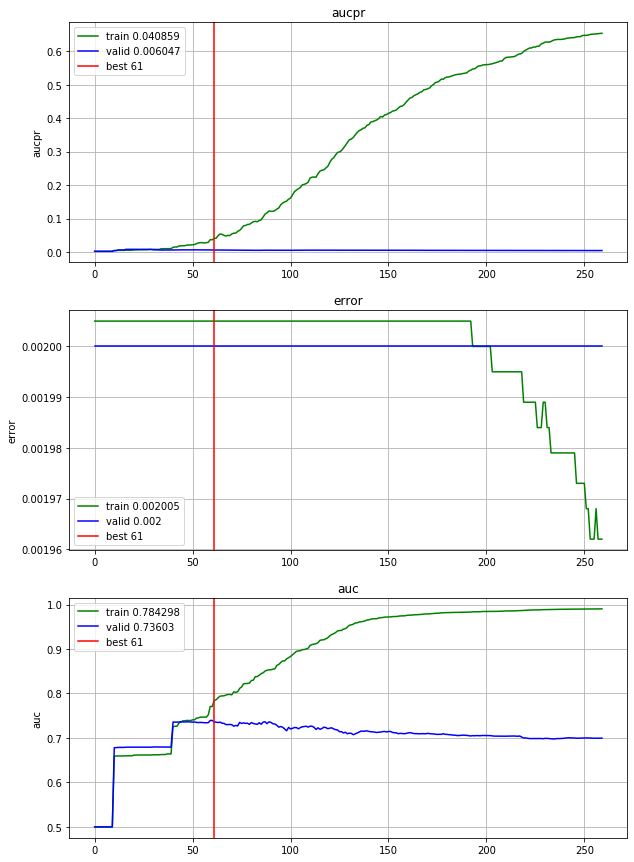

In [124]:
plot_perf(evals_result, xgb_model.best_ntree_limit)

In [38]:
train_preds = xgb_model.predict(d_train, ntree_limit=xgb_model.best_ntree_limit)
valid_preds = xgb_model.predict(d_valid, ntree_limit=xgb_model.best_ntree_limit)

In [39]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
# from sklearn.metrics import plot_roc_curve  # only sklearn after version 0.22 
from sklearn.metrics import precision_recall_curve
from scikitplot.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

In [40]:
print('Train AUC =',roc_auc_score(y_train, train_preds))
print('Valid AUC =',roc_auc_score(y_valid, valid_preds))

Train AUC = 0.7841419061464051
Valid AUC = 0.7391515323896403


In [41]:
from sklearn import metrics
def buildROC(target_test,test_preds,label=None, color='b'):
    '''Compute micro-average ROC curve and ROC area
        could be replaced by sklearn.metrics.plot_auc_curve in 0.22
    '''
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.rcParams["figure.figsize"] = (6,6)
    plt.plot(fpr, tpr, 'b', label = label+' AUC = %0.4f' % roc_auc, color=color)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('AUC')
    return 

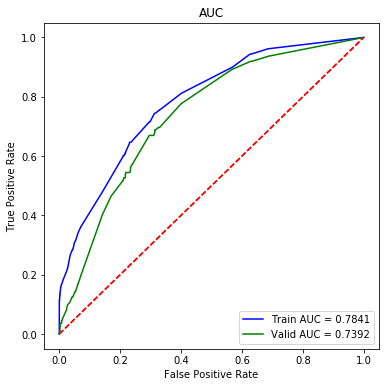

In [42]:
ax = buildROC(y_train, train_preds, label='Train')
buildROC(y_valid, valid_preds, label='Valid', color='g')

## Eval Test - this is broken ??? as y_test isn't properly mapped

In [43]:
# Predict on test data
d_test = xgb.DMatrix(X_test, y_test, feature_names=test_features)

preds = xgb_model.predict(d_test, ntree_limit=xgb_model.best_ntree_limit)

NameError: name 'X_test' is not defined

In [ ]:
y_scores = preds

In [ ]:
print('AUC =',roc_auc_score(y_test, y_scores))

In [ ]:
# fig, ax = plt.subplots()
# plot_roc_curve(xgb_model, X_test, y_test, ax=ax)
# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#         label='Chance', alpha=.8)

# ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
#        title="AUC")
# ax.legend(loc="lower right")
# plt.show()

In [ ]:
buildROC(y_test,preds)

In [ ]:
# !pip install scikit-plot

In [ ]:
# import scikitplot as skplt
# plt.rcParams["figure.figsize"] = (10,10)
# skplt.metrics.plot_roc(y_test, preds)

In [ ]:
average_precision = average_precision_score(y_test, y_scores)
print('PRAUC = ', average_precision)

In [ ]:
plt.rcParams["figure.figsize"] = (15,40)
ax = xgb.plot_importance(xgb_model)

In [ ]:
importance = xgb_model.get_fscore()
importance = pd.DataFrame.from_dict(importance.items())
importance.columns=['column','importance']
importance.sort_values(by='importance', ascending=False)

In [ ]:
importance = importance.set_index('column').join(col_concepts.set_index('column'),how='left').sort_values(by='importance', ascending=False)

In [ ]:
importance[10:50]

In [ ]:
observation = pd.read_csv('v2/app/concept_codes_final/observation_concepts.csv')
observation.head()

In [ ]:
observation[observation.observation_concept_id == 4058860]

## Full train

In [ ]:
params = {
    'eval_metric': 'auc',
    'tree_method' : 'auto',
    'random_state' : 1234,
    'reg_lambda' : 1.0,
    'min_child_weight' : 1.0,
    'max_bin' : 256,
    'min_split_loss' : 0.01,
    'max_depth' : 10,
    'reg_alpha' : 0.0,
    'colsample_bylevel' : 1.0,
    'scale_pos_weight' : 1.0,
    'max_delta_step' : 0.0,
    'learning_rate' : 0.05,
    'n_estimators' : 1000,
    'num_parallel_tree' : 1,
    'colsample_bytree' : 0.5,
    'subsample' : 1.0,
    'n_jobs': -1.0,
}

num_round = 100

In [ ]:
df_preds = pd.DataFrame()
evals_result ={}

d_train_full = xgb.DMatrix(X, y, feature_names=train_features)
watchlist = [(d_train_full, 'train_full')]

xgb_model = xgb.train(params, d_train_full, num_round, watchlist,
                      early_stopping_rounds=50, maximize=True, 
                      verbose_eval=False, callbacks=[xgb_progressbar(num_round), ])

print(xgb_model.best_score, xgb_model.best_ntree_limit)

In [ ]:
model_file = 'xgb_model.joblib'
dump(xgb_model, model_file)

In [ ]:
xgb_model_2 = load(model_file)
type(xgb_model_2)